<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl


from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io

WEIGHTSANDBIASES = True
DOWNLOAD = True
# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'

# from google.colab import drive
# drive.mount('/content/drive')

if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/sample_data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/sample_data/ham

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)


  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)


  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  print(train_data.__getdist__())
  print(train_data.len)

  return train_data, test_data,validation_data


In [6]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data.__getitem__(i)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)

    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [7]:
def get_weights():
  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  valors = metadates['dx'].value_counts()
  print(valors)
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1



  weights[1] *= 2.0
  weights[3] *= 2.0
  weights[4] *= 2.0


  weights = weights / weights.sum()


  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4])

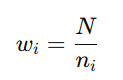

[0.00657042, **0.03958192**, 0.04008614, **0.08570948**, **0.13472377**, 0.31024417,
 0.3830841 ]

 provarem a augmentar en 1.5 els pesos de les enfermetats perilloses:

[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052,
 0.33901021]

 i en 2.0:

 [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257,
 0.30403135]

 Això pujarà el pes conjunt de les classes perilloses fins a 41%

In [8]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [9]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
    resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 6:
    # alexnetmulticlass = models.alexnet(weights=None)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Linear(9216, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 1024),
    # nn.ReLU(),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(),
    # torch.nn.Linear(512, 7),  # Ja que tenim 7 classes.
    # nn.Softmax(dim=1)
    # )
    # loss_fn = nn.CrossEntropyLoss()

    # return alexnetmulticlass,loss_fn
    return




In [10]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [11]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
        target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
        target = target.to(device)


        input_img = input_img.to(device)
        output = model(input_img.to(device))

        loss = loss_fn(output, target.float())

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,zero_division=1)
        train_recall += recall_score(target,output,zero_division=1)
        train_precision += precision_score(target,output,zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [12]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):
            input_img = input_img.to(device)


            target = torch.unsqueeze(target, 1)
            target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no
            target = target.to(device)

            output = model(input_img)
            loss = loss_fn(output, target.float())

            output = torch.sigmoid(output)
            output = (output.cpu().detach().numpy() > 0.5).astype(int)
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,zero_division=1)
            val_recall += recall_score(target,output,zero_division=1)
            val_precision += precision_score(target,output,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [13]:
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)
  architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet'}

  patiente = 100
  best_recall = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)

      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

        # torch.save(model, "my_model.pt")
        # wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")

      if val_recall > best_recall:
        best_recall = val_recall
        patiente = 100
      else:
        patiente -= 1

      if patiente == 0:
        print("Early Sopping")
        break

  wandb.finish()

In [14]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet': 1,'resnet152':2}
MODEL = architectures['resnet152']

TRAINING = 0.75
VALIDATION = 0.15
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
#FINE_TUNING = [None,models.AlexNet_Weights.IMAGENET1K_V1]
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    #transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

#load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)

#Realitzar el tuning de hiperparàmetres aquí


EPOCHS = 50
batch_size = 32

#[0.00657042, 0.03958192, 0.04008614, 0.08570948, 0.13472377, 0.31024417, 0.3830841 ]
# WEIGHTS = [[0.00581449, 0.05254201, 0.03547423, 0.11377288, 0.17883566, 0.27455052, 0.33901021],
#  [0.00521456, 0.06282768, 0.03181402, 0.13604515, 0.21384468, 0.24622257, 0.30403135]]

#WEIGHTS = [2.33,1.5]

#get_weights()
WEIGHTS = [get_weights()]

learning_rate  = 1e-5

for weights in product(WEIGHTS):

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  model,loss_fn = tria_model(MODEL,weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model.to(device)

  projectes = ['Ham10000-AlexnetBinary','Ham1000-ResnetBinary','Ham1000-Resnet152Binary']

  #print(f"{batch_size} , {weights} , {learning_rate}")
  if WEIGHTSANDBIASES:
      wandb.init(
              project=projectes[MODEL],
              config={
                  "epochs": EPOCHS,
                  "batch_size": batch_size,
                  "lr": learning_rate,
                  "trsize":len(train_loader),
                  "trdist":TRAINING,
                  "vsize":len(val_loader),
                  "vdist":VALIDATION,
                  "weights":weights,
                  })
      config = wandb.config
      print(config)

  execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)

0    5028
1     835
2     824
3     386
4     245
5     106
6      86
Name: count, dtype: int64
7510
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 173MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 235, 'trdist': 0.75, 'vsize': 32, 'vdist': 0.15, 'weights': [1.4229647861576398]}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 0.5064612450751852
Accuracy train epoch: 1  train_acc: 0.7644463249516441
F1 train epoch: 1  train_f1: 0.5729314124200384
Recall train epoch: 1  train_recall: 0.7794438894438891


Pèrdua validació epoch: 1  val_loss: 0.37137209670618176
Accuracy val epoch: 1  val_acc: 0.858203125
F1 val epoch: 1  val_f1: 0.6390137638503419
Recall val epoch: 1  val_reall: 0.7495851370851373


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.33160894773107896
Accuracy train epoch: 2  train_acc: 0.8822050290135396
F1 train epoch: 2  train_f1: 0.6857583170622498
Recall train epoch: 2  train_recall: 0.7273169383807684


Pèrdua validació epoch: 2  val_loss: 0.32438559737056494
Accuracy val epoch: 2  val_acc: 0.8935546875
F1 val epoch: 2  val_f1: 0.6668818322093285
Recall val epoch: 2  val_reall: 0.5889632936507936


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.2837265819945234
Accuracy train epoch: 3  train_acc: 0.9025386847195358
F1 train epoch: 3  train_f1: 0.7330709790761829
Recall train epoch: 3  train_recall: 0.7689777834458683


Pèrdua validació epoch: 3  val_loss: 0.31858589174225926
Accuracy val epoch: 3  val_acc: 0.893359375
F1 val epoch: 3  val_f1: 0.6631836913086915
Recall val epoch: 3  val_reall: 0.5719687430624932


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.24600420917602295
Accuracy train epoch: 4  train_acc: 0.9151112185686654
F1 train epoch: 4  train_f1: 0.7706582446602872
Recall train epoch: 4  train_recall: 0.8016668201774584


Pèrdua validació epoch: 4  val_loss: 0.2990682527888566
Accuracy val epoch: 4  val_acc: 0.8953125
F1 val epoch: 4  val_f1: 0.703056823691015
Recall val epoch: 4  val_reall: 0.6752604166666668


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.2075097885220609
Accuracy train epoch: 5  train_acc: 0.9286025145067698
F1 train epoch: 5  train_f1: 0.8107259530097293
Recall train epoch: 5  train_recall: 0.8442718983144512


Pèrdua validació epoch: 5  val_loss: 0.31037829583510756
Accuracy val epoch: 5  val_acc: 0.890234375
F1 val epoch: 5  val_f1: 0.7065022017932487
Recall val epoch: 5  val_reall: 0.7275342712842714


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.18087556809186936
Accuracy train epoch: 6  train_acc: 0.9385880077369438
F1 train epoch: 6  train_f1: 0.8328867814998222
Recall train epoch: 6  train_recall: 0.8757993661185155


Pèrdua validació epoch: 6  val_loss: 0.34282832802273333
Accuracy val epoch: 6  val_acc: 0.8990234375
F1 val epoch: 6  val_f1: 0.6772746818025458
Recall val epoch: 6  val_reall: 0.613938492063492


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.16238410040102105
Accuracy train epoch: 7  train_acc: 0.9446204061895552
F1 train epoch: 7  train_f1: 0.8475641353208707
Recall train epoch: 7  train_recall: 0.8868780746440323


Pèrdua validació epoch: 7  val_loss: 0.33118639420717955
Accuracy val epoch: 7  val_acc: 0.8923828125
F1 val epoch: 7  val_f1: 0.6812461991375499
Recall val epoch: 7  val_reall: 0.638016323953824


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.1384151140663852
Accuracy train epoch: 8  train_acc: 0.9555246615087041
F1 train epoch: 8  train_f1: 0.8742699668715748
Recall train epoch: 8  train_recall: 0.9030177151453749


Pèrdua validació epoch: 8  val_loss: 0.3390636926051229
Accuracy val epoch: 8  val_acc: 0.90625
F1 val epoch: 8  val_f1: 0.7033854647244743
Recall val epoch: 8  val_reall: 0.6428391053391054


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.12263191672081643
Accuracy train epoch: 9  train_acc: 0.9622340425531914
F1 train epoch: 9  train_f1: 0.8986484797287777
Recall train epoch: 9  train_recall: 0.9228704392534182


Pèrdua validació epoch: 9  val_loss: 0.3473061913391575
Accuracy val epoch: 9  val_acc: 0.8970703125
F1 val epoch: 9  val_f1: 0.7276395831228457
Recall val epoch: 9  val_reall: 0.7259097673160175


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.11098810122843752
Accuracy train epoch: 10  train_acc: 0.9658365570599613
F1 train epoch: 10  train_f1: 0.904955298966234
Recall train epoch: 10  train_recall: 0.9341843971631212


Pèrdua validació epoch: 10  val_loss: 0.3498856609221548
Accuracy val epoch: 10  val_acc: 0.893359375
F1 val epoch: 10  val_f1: 0.6645066279717018
Recall val epoch: 10  val_reall: 0.6105733676046177


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.09532606212144837
Accuracy train epoch: 11  train_acc: 0.969281914893617
F1 train epoch: 11  train_f1: 0.9109722003691444
Recall train epoch: 11  train_recall: 0.9470098813715838


Pèrdua validació epoch: 11  val_loss: 0.34899515222059563
Accuracy val epoch: 11  val_acc: 0.9078125
F1 val epoch: 11  val_f1: 0.7049455529742876
Recall val epoch: 11  val_reall: 0.6668278769841269


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.09674201156309944
Accuracy train epoch: 12  train_acc: 0.9709622823984526
F1 train epoch: 12  train_f1: 0.922719528617823
Recall train epoch: 12  train_recall: 0.9464990328820118


Pèrdua validació epoch: 12  val_loss: 0.339230845682323
Accuracy val epoch: 12  val_acc: 0.9099609375
F1 val epoch: 12  val_f1: 0.7089530261405261
Recall val epoch: 12  val_reall: 0.6473185668498169


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.08054663324134147
Accuracy train epoch: 13  train_acc: 0.9758704061895552
F1 train epoch: 13  train_f1: 0.9289865892401958
Recall train epoch: 13  train_recall: 0.9562615516870838


Pèrdua validació epoch: 13  val_loss: 0.3667144614737481
Accuracy val epoch: 13  val_acc: 0.9099609375
F1 val epoch: 13  val_f1: 0.7203498931623935
Recall val epoch: 13  val_reall: 0.6388826884920636


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.07159374597224784
Accuracy train epoch: 14  train_acc: 0.9775991295938105
F1 train epoch: 14  train_f1: 0.9357849333319674
Recall train epoch: 14  train_recall: 0.9576806644891751


Pèrdua validació epoch: 14  val_loss: 0.3638632008805871
Accuracy val epoch: 14  val_acc: 0.898828125
F1 val epoch: 14  val_f1: 0.682067069980673
Recall val epoch: 14  val_reall: 0.6941806457431459


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.06361600990070307
Accuracy train epoch: 15  train_acc: 0.9808510638297873
F1 train epoch: 15  train_f1: 0.9439743739269463
Recall train epoch: 15  train_recall: 0.9665311166374999


Pèrdua validació epoch: 15  val_loss: 0.4142921380116604
Accuracy val epoch: 15  val_acc: 0.898046875
F1 val epoch: 15  val_f1: 0.6683119270435447
Recall val epoch: 15  val_reall: 0.6092228084415586


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.06733311751976293
Accuracy train epoch: 16  train_acc: 0.9797872340425532
F1 train epoch: 16  train_f1: 0.9434591768667258
Recall train epoch: 16  train_recall: 0.9553664893026597


Pèrdua validació epoch: 16  val_loss: 0.41622790627297945
Accuracy val epoch: 16  val_acc: 0.908203125
F1 val epoch: 16  val_f1: 0.7309453567266068
Recall val epoch: 16  val_reall: 0.6955109126984128


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.056508282023145166
Accuracy train epoch: 17  train_acc: 0.9827127659574468
F1 train epoch: 17  train_f1: 0.9483661532898742
Recall train epoch: 17  train_recall: 0.9704193914832214


Pèrdua validació epoch: 17  val_loss: 0.38816128761391155
Accuracy val epoch: 17  val_acc: 0.9052734375
F1 val epoch: 17  val_f1: 0.7182073231850711
Recall val epoch: 17  val_reall: 0.6749379960317462


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.05231031068858314
Accuracy train epoch: 18  train_acc: 0.9854448742746615
F1 train epoch: 18  train_f1: 0.9593415313497334
Recall train epoch: 18  train_recall: 0.9763944920327903


Pèrdua validació epoch: 18  val_loss: 0.40861011762171984
Accuracy val epoch: 18  val_acc: 0.9
F1 val epoch: 18  val_f1: 0.6843778617216117
Recall val epoch: 18  val_reall: 0.6678526334776335


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.05131760279033729
Accuracy train epoch: 19  train_acc: 0.9845140232108318
F1 train epoch: 19  train_f1: 0.9527956276197843
Recall train epoch: 19  train_recall: 0.9721923938945217


Pèrdua validació epoch: 19  val_loss: 0.35532291189883836
Accuracy val epoch: 19  val_acc: 0.916015625
F1 val epoch: 19  val_f1: 0.7567904470937561
Recall val epoch: 19  val_reall: 0.7535342261904763


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.061773856608395246
Accuracy train epoch: 20  train_acc: 0.980718085106383
F1 train epoch: 20  train_f1: 0.936615420880853
Recall train epoch: 20  train_recall: 0.9671248963802156


Pèrdua validació epoch: 20  val_loss: 0.3132140371017158
Accuracy val epoch: 20  val_acc: 0.9177734375
F1 val epoch: 20  val_f1: 0.7436115510951039
Recall val epoch: 20  val_reall: 0.7188830266955266


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.05295429187034197
Accuracy train epoch: 21  train_acc: 0.9851063829787234
F1 train epoch: 21  train_f1: 0.9505521551095966
Recall train epoch: 21  train_recall: 0.9736707500537289


Pèrdua validació epoch: 21  val_loss: 0.3222974316740874
Accuracy val epoch: 21  val_acc: 0.9205078125
F1 val epoch: 21  val_f1: 0.7737163061611594
Recall val epoch: 21  val_reall: 0.7493923611111113


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.045995898207927
Accuracy train epoch: 22  train_acc: 0.9844414893617022
F1 train epoch: 22  train_f1: 0.9532253442493217
Recall train epoch: 22  train_recall: 0.973962727579749


Pèrdua validació epoch: 22  val_loss: 0.3350234559038654
Accuracy val epoch: 22  val_acc: 0.91484375
F1 val epoch: 22  val_f1: 0.7575435899884431
Recall val epoch: 22  val_reall: 0.7796130952380952


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.047320457242746305
Accuracy train epoch: 23  train_acc: 0.9855778529980658
F1 train epoch: 23  train_f1: 0.9579370444446209
Recall train epoch: 23  train_recall: 0.9760223818734458


Pèrdua validació epoch: 23  val_loss: 0.3646468901424669
Accuracy val epoch: 23  val_acc: 0.9158203125
F1 val epoch: 23  val_f1: 0.751761774785672
Recall val epoch: 23  val_reall: 0.7508398719336219


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.04589000547384011
Accuracy train epoch: 24  train_acc: 0.9868351063829788
F1 train epoch: 24  train_f1: 0.961810989387832
Recall train epoch: 24  train_recall: 0.9780008407667984


Pèrdua validació epoch: 24  val_loss: 0.387795515707694
Accuracy val epoch: 24  val_acc: 0.908984375
F1 val epoch: 24  val_f1: 0.7315322137013317
Recall val epoch: 24  val_reall: 0.7039930555555557


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.03469962763818021
Accuracy train epoch: 25  train_acc: 0.9900265957446809
F1 train epoch: 25  train_f1: 0.968715775151881
Recall train epoch: 25  train_recall: 0.9802805823018589


Pèrdua validació epoch: 25  val_loss: 0.3966273239348084
Accuracy val epoch: 25  val_acc: 0.9138671875
F1 val epoch: 25  val_f1: 0.7019180472305474
Recall val epoch: 25  val_reall: 0.673757665945166


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.03151074137558487
Accuracy train epoch: 26  train_acc: 0.9902925531914893
F1 train epoch: 26  train_f1: 0.9675322954497586
Recall train epoch: 26  train_recall: 0.9828580639218939


Pèrdua validació epoch: 26  val_loss: 0.4476044501061551
Accuracy val epoch: 26  val_acc: 0.91484375
F1 val epoch: 26  val_f1: 0.7284164711385106
Recall val epoch: 26  val_reall: 0.647303391053391


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.03770533064479365
Accuracy train epoch: 27  train_acc: 0.9888297872340426
F1 train epoch: 27  train_f1: 0.9629980243354856
Recall train epoch: 27  train_recall: 0.9786825231506084


Pèrdua validació epoch: 27  val_loss: 0.34043520523118787
Accuracy val epoch: 27  val_acc: 0.927734375
F1 val epoch: 27  val_f1: 0.7974798442871199
Recall val epoch: 27  val_reall: 0.800545634920635


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.033440821103632765
Accuracy train epoch: 28  train_acc: 0.9890352998065765
F1 train epoch: 28  train_f1: 0.9684485499998657
Recall train epoch: 28  train_recall: 0.9776272899677158


Pèrdua validació epoch: 28  val_loss: 0.37031877390109
Accuracy val epoch: 28  val_acc: 0.9109375
F1 val epoch: 28  val_f1: 0.7598933705183708
Recall val epoch: 28  val_reall: 0.7781145070207572


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.035383076485781435
Accuracy train epoch: 29  train_acc: 0.9879714700193424
F1 train epoch: 29  train_f1: 0.9641316264839433
Recall train epoch: 29  train_recall: 0.9769519959945492


Pèrdua validació epoch: 29  val_loss: 0.33009804922767216
Accuracy val epoch: 29  val_acc: 0.9248046875
F1 val epoch: 29  val_f1: 0.7843906450983656
Recall val epoch: 29  val_reall: 0.7723958333333335


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.02985963363576918
Accuracy train epoch: 30  train_acc: 0.9918882978723405
F1 train epoch: 30  train_f1: 0.9759568744342163
Recall train epoch: 30  train_recall: 0.9855723472744748


Pèrdua validació epoch: 30  val_loss: 0.37291599811578635
Accuracy val epoch: 30  val_acc: 0.919921875
F1 val epoch: 30  val_f1: 0.7783764482533665
Recall val epoch: 30  val_reall: 0.7665922619047619


Batches (Època 31): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 31  train_loss: 0.03378433752160995
Accuracy train epoch: 31  train_acc: 0.9899661508704063
F1 train epoch: 31  train_f1: 0.9694732034903302
Recall train epoch: 31  train_recall: 0.9832941408473324


Pèrdua validació epoch: 31  val_loss: 0.3922495383885689
Accuracy val epoch: 31  val_acc: 0.9060546875
F1 val epoch: 31  val_f1: 0.7168818869791199
Recall val epoch: 31  val_reall: 0.6777766504329005


Batches (Època 32): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 32  train_loss: 0.03722319092522276
Accuracy train epoch: 32  train_acc: 0.9897606382978723
F1 train epoch: 32  train_f1: 0.9694356366028196
Recall train epoch: 32  train_recall: 0.9791197691197692


Pèrdua validació epoch: 32  val_loss: 0.3584492346199113
Accuracy val epoch: 32  val_acc: 0.91875
F1 val epoch: 32  val_f1: 0.7783516627748273
Recall val epoch: 32  val_reall: 0.7634661345598847


Batches (Època 33): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 33  train_loss: 0.028545119048175503
Accuracy train epoch: 33  train_acc: 0.9914893617021276
F1 train epoch: 33  train_f1: 0.9756278144269712
Recall train epoch: 33  train_recall: 0.9862506524208652


Pèrdua validació epoch: 33  val_loss: 0.38862607371993363
Accuracy val epoch: 33  val_acc: 0.92265625
F1 val epoch: 33  val_f1: 0.7599456099456101
Recall val epoch: 33  val_reall: 0.74727408008658


Batches (Època 34): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 34  train_loss: 0.031233891619844956
Accuracy train epoch: 34  train_acc: 0.9902925531914893
F1 train epoch: 34  train_f1: 0.9687652787875463
Recall train epoch: 34  train_recall: 0.9845405422001169


Pèrdua validació epoch: 34  val_loss: 0.36445214482955635
Accuracy val epoch: 34  val_acc: 0.9048828125
F1 val epoch: 34  val_f1: 0.7341297787754453
Recall val epoch: 34  val_reall: 0.7481601731601731


Batches (Època 35): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 35  train_loss: 0.0258057147948111
Accuracy train epoch: 35  train_acc: 0.9921542553191489
F1 train epoch: 35  train_f1: 0.9717068344586294
Recall train epoch: 35  train_recall: 0.9888073746584386


Pèrdua validació epoch: 35  val_loss: 0.3651776290789712
Accuracy val epoch: 35  val_acc: 0.9228515625
F1 val epoch: 35  val_f1: 0.7898374093227035
Recall val epoch: 35  val_reall: 0.7427308802308803


Batches (Època 36): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 36  train_loss: 0.021916570673458913
Accuracy train epoch: 36  train_acc: 0.9946808510638298
F1 train epoch: 36  train_f1: 0.9833289361091563
Recall train epoch: 36  train_recall: 0.9929145558932794


Pèrdua validació epoch: 36  val_loss: 0.42737003597721923
Accuracy val epoch: 36  val_acc: 0.915625
F1 val epoch: 36  val_f1: 0.7388649544899546
Recall val epoch: 36  val_reall: 0.7230508207070706


Batches (Època 37): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 37  train_loss: 0.02278486201935943
Accuracy train epoch: 37  train_acc: 0.9938829787234043
F1 train epoch: 37  train_f1: 0.9780827580590445
Recall train epoch: 37  train_recall: 0.989714316416444


Pèrdua validació epoch: 37  val_loss: 0.41555446836719057
Accuracy val epoch: 37  val_acc: 0.91171875
F1 val epoch: 37  val_f1: 0.7295504939032417
Recall val epoch: 37  val_reall: 0.686084054834055


Batches (Època 38): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 38  train_loss: 0.024471783366529866
Accuracy train epoch: 38  train_acc: 0.9941489361702127
F1 train epoch: 38  train_f1: 0.9788146753221861
Recall train epoch: 38  train_recall: 0.9901146843700035


Pèrdua validació epoch: 38  val_loss: 0.4172872277413262
Accuracy val epoch: 38  val_acc: 0.9140625
F1 val epoch: 38  val_f1: 0.7581378190845105
Recall val epoch: 38  val_reall: 0.7465544871794874


Batches (Època 39): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 39  train_loss: 0.023507802112602647
Accuracy train epoch: 39  train_acc: 0.9928191489361702
F1 train epoch: 39  train_f1: 0.979100572733833
Recall train epoch: 39  train_recall: 0.990289119863588


Pèrdua validació epoch: 39  val_loss: 0.4691439764428651
Accuracy val epoch: 39  val_acc: 0.905859375
F1 val epoch: 39  val_f1: 0.7364046186656482
Recall val epoch: 39  val_reall: 0.7019514339826839


Batches (Època 40): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 40  train_loss: 0.022388802368709066
Accuracy train epoch: 40  train_acc: 0.9934840425531914
F1 train epoch: 40  train_f1: 0.9782326203957217
Recall train epoch: 40  train_recall: 0.9907109084768659


Pèrdua validació epoch: 40  val_loss: 0.4660744968568906
Accuracy val epoch: 40  val_acc: 0.913671875
F1 val epoch: 40  val_f1: 0.7213578955766456
Recall val epoch: 40  val_reall: 0.6827008928571427


Batches (Època 41): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 41  train_loss: 0.02841424261457584
Accuracy train epoch: 41  train_acc: 0.9916223404255319
F1 train epoch: 41  train_f1: 0.9778552735917233
Recall train epoch: 41  train_recall: 0.987163888121335


Pèrdua validació epoch: 41  val_loss: 0.43391568468359765
Accuracy val epoch: 41  val_acc: 0.9224609375
F1 val epoch: 41  val_f1: 0.7870916346944623
Recall val epoch: 41  val_reall: 0.7635044642857144


Batches (Època 42): 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(training.__len__())